## Silverbox

Silverbox is the name of a nonlinear system identification benchmark, proposed in 2004. Data, baselines and more info can be found at http://nonlinearbenchmark.org/#Silverbox.

State-space formulation of Silverbox's dynamics:

$$\begin{align}
\mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + \kappa(x(t)) x(t) =&\ u(t) + w(t) \\
\kappa(x(t)) =&\ \alpha + \beta x^2(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
\mu     =&\ \text{mass} \\
\nu     =&\ \text{viscous damping} \\
\kappa(x(t)) =&\ \text{nonlinear spring} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

### Steps to solve

I now take a series of steps to re-write this problem:

#### 1. Assume constant spring coefficient κ

$$ \mu \frac{d^2 x(t)}{dt^2} + \nu \frac{d x(t)}{dt} + κ x(t) = u(t) + w(t)$$

#### 2. Divide by leading coefficient

$$ \frac{d^2 x(t)}{dt^2} + \frac{\nu}{\mu} \frac{d x(t)}{dt} + \frac{κ}{\mu} x(t) = \frac{1}{\mu} u(t) + \frac{1}{\mu} w(t)$$

#### 3. Substitute standard variables

$$ \frac{d^2 x(t)}{dt^2} + 2\zeta \omega_0 \frac{d x(t)}{dt} + \omega_0^2 x(t) - \frac{u(t)}{\mu} = \frac{w(t)}{\mu}$$

where $$\begin{align} 
\zeta =&\ \frac{\nu}{2\sqrt{\mu \kappa}} \\ 
\omega_0 =&\ \sqrt{\frac{\kappa}{\mu}} \, .
\end{align}$$

#### 4. Apply Euler's method to obtain difference equation (step size is 1)

-> Forward Euler:

$$\begin{align}
\frac{x(t+2h)-2x(t+h)+x(t)}{h^2} + 2\zeta \omega_0 \frac{x(t+h)-x(t)}{h} + \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu} \\
x(t+2) + 2(\zeta \omega_0 - 1) x(t+1) + (1 - 2 \zeta \omega_0 + \omega_0^2) x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu} 
\end{align}$$

-> Backward Euler:

$$\begin{align}
\frac{x(t)-2x(t-h)+x(t-2h)}{h^2} - 2\zeta \omega_0 \frac{x(t)-x(t-h)}{h} - \omega_0^2 x(t) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu}  \\
(1 + 2 \zeta \omega_0 + \omega_0^2)x(t) - 2(1 + \zeta \omega_0)x(t-1) - x(t-2) - \frac{u(t)}{\mu} =&\ \frac{w(t)}{\mu} \\
x(t) - \frac{2(1 + \zeta \omega_0)}{(1 + 2\zeta \omega_0 + \omega_0^2)}x(t-1) - \frac{1}{(1 + 2\zeta \omega_0 + \omega_0^2)}x(t-2) - \frac{u(t)}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)} =&\ \frac{w(t)}{\mu(1 + 2\zeta \omega_0 + \omega_0^2)}
\end{align}$$
    
Change to shorthand notation:

$$x_t - \theta_1 x_{t-1} - \theta_2 x_{t-2} - \eta u_t = \gamma w_t$$

where 
$$\begin{align} 
\theta_1 =&\ \frac{2(1 + \zeta \omega_0)}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\theta_2 =&\ \frac{1}{1 + 2\zeta \omega_0 + \omega_0^2} \\
\eta =&\ \frac{1}{\mu(1 + 2 \zeta \omega_0 + \omega_0^2)}
\end{align}$$

Given three equations and three unknowns, I can recover $\zeta$, $\omega_0$ and $\mu$ from $\theta_1$, $\theta_2$, and $\eta$.

#### 5. Convert to multivariate first-order difference form

Stick to backward Euler (matches AR structure)
- Backward Euler:

    $$z_t = A(\theta) z_{t-1} + c\eta u_t + c\eta w_t$$

    where $z_t = [x_t\ \ x_{t-1}]$, $A(\theta) = [\theta_1 \ \ \theta_2; 1\ \ 0]$, $c = [1\ \ 0]$.

#### 6. Convert to Gaussian probability

- Backward Euler:

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, c\eta \tau)$$

for $w_t \sim \mathcal{N}(0, \tau)$.

#### 7. Observation likelihood

$$y_t \sim \mathcal{N}(c z_t, σ)$$

where $e_t \sim \mathcal{N}(0, \sigma)$.

I will first study a situation with known measurement noise (so $\sigma$ is fixed). That means I need priors for $\theta$, $\eta$, and $\tau$. The variables are all strictly positive, which means they can be modeled by log-normal and gamma distributions:

$$\begin{align}
\log(\theta) \sim&\ \mathcal{N}(m_\theta, W_\theta) \\
\log(\eta) \sim&\ \mathcal{N}(m_\eta, W_\eta) \\
\tau \sim&\ Γ(a_\tau, b_\tau) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [3]:
using Plots

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
Plots.savefig(p1, "viz/output_signal.png")

In [5]:
p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
Plots.savefig(p2, "viz/input_signal.png")

## Implementation

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1273


I will use the Nonlinear node to cope with a log-normal distribution.

In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV lθ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV lη ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Nonlinear function
g(x) = exp.(x)
g_inv(x) = log.(x)

# Nonlinear node
# @RV θ ~ Nonlinear{Unscented}(log_θ; g=g, g_inv=g_inv, dims=(2,)) # DomainError on log as g_inv
@RV θ ~ Nonlinear{Unscented}(lθ; g=g, dims=(2,))
@RV η ~ Nonlinear{Unscented}(lη; g=g, dims=(1,))

# I'm fixing measurement noise σ
σ = 0.001

# Observation selection variable
c = [1, 0]

# Placeholder for control
# @RV u_t ~ GaussianMeanPrecision(placeholder(:m_u), 1e12, id=:u_t)

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:W_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), τ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanVariance(dot(c, x_t), σ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14039151407259843758 -->
 
 14039151407259843758 
 
 placeholder_y_t 
 
<!-- 17736162894015677434 -->
 
 17736162894015677434 
 
 𝒩 
 y_t 
 
<!-- 14039151407259843758--17736162894015677434 -->
 
 14039151407259843758--17736162894015677434 
 
 y_t 
 1 out 
 1 out 
 
<!-- 15444216762999006496 -->
 
 15444216762999006496 
 
 clamp_2 
 
<!-- 11937017766040613689 -->
 
 11937017766040613689 
 
 placeholder_w_η 
 
<!-- 12691804059482315829 -->
 
 12691804059482315829 
 
 Nonlinear{Unscented} 
 nonlinear_2 
 
<!-- 17850437785681487052 -->
 
 17850437785681487052 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12691804059482315829--17850437785681487052 -->
 
 12691804059482315829--17850437785681487052 
 
 lη 
 1 out 
 2 in1 
 
<!-- 9432311997417080077 -->
 
 9432311997417080077 
 
 placeholder_b_τ 
 
<!-- 11986530677229478198 -->
 
 11986530677229478198 
 
 𝒩 
 z_t 
 
<!-- 15794377618987991099 -->
 
 15794377618987991099 
 
 placeholder_m_z 
 
<!-- 11986530677229478198--15794377618987991099 -->
 
 11986530677229478198--15794377618987991099 
 
 m_z 
 1 out 
 2 m 
 
<!-- 17916737684979649199 -->
 
 17916737684979649199 
 
 placeholder_W_z 
 
<!-- 11986530677229478198--17916737684979649199 -->
 
 11986530677229478198--17916737684979649199 
 
 W_z 
 1 out 
 3 w 
 
<!-- 217221402744358338 -->
 
 217221402744358338 
 
 placeholder_m_θ 
 
<!-- 1537353917299990059 -->
 
 1537353917299990059 
 
 Nonlinear{Unscented} 
 nonlinear_1 
 
<!-- 5994847908996418814 -->
 
 5994847908996418814 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1537353917299990059--5994847908996418814 -->
 
 1537353917299990059--5994847908996418814 
 
 lθ 
 1 out 
 2 in1 
 
<!-- 5994847908996418814--217221402744358338 -->
 
 5994847908996418814--217221402744358338 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 13097243782212482769 -->
 
 13097243782212482769 
 
 placeholder_W_θ 
 
<!-- 5994847908996418814--13097243782212482769 -->
 
 5994847908996418814--13097243782212482769 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 17850437785681487052--11937017766040613689 -->
 
 17850437785681487052--11937017766040613689 
 
 w_η 
 1 out 
 3 w 
 
<!-- 1487858061572043640 -->
 
 1487858061572043640 
 
 placeholder_m_η 
 
<!-- 17850437785681487052--1487858061572043640 -->
 
 17850437785681487052--1487858061572043640 
 
 m_η 
 1 out 
 2 m 
 
<!-- 3016495731849416769 -->
 
 3016495731849416769 
 
 placeholder_u_t 
 
<!-- 5442118502566568768 -->
 
 5442118502566568768 
 
 Gam 
 gamma_1 
 
<!-- 5442118502566568768--9432311997417080077 -->
 
 5442118502566568768--9432311997417080077 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 7924148906627639011 -->
 
 7924148906627639011 
 
 placeholder_a_τ 
 
<!-- 5442118502566568768--7924148906627639011 -->
 
 5442118502566568768--7924148906627639011 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 17736162894015677434--15444216762999006496 -->
 
 17736162894015677434--15444216762999006496 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 1307832122135555274 -->
 
 1307832122135555274 
 
 dot 
 dotproduct_1 
 
<!-- 17736162894015677434--1307832122135555274 -->
 
 17736162894015677434--1307832122135555274 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 6448666116814500932 -->
 
 6448666116814500932 
 
 clamp_1 
 
<!-- 1307832122135555274--6448666116814500932 -->
 
 1307832122135555274--6448666116814500932 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 6480474784054197445 -->
 
 6480474784054197445 
 
 ARC 
 x_t 
 
<!-- 1307832122135555274--6480474784054197445 -->
 
 1307832122135555274--6480474784054197445 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 6480474784054197445--12691804059482315829 -->
 
 6480474784054197445--12691804059482315829 
 
 η 
 1 out 
 4 η 
 
<!-- 6480474784054197445--11986530677229478198 -->
 
 6480474784054197445--11986530677229478198 
 
 z_t 
 1 out 
 2 x 
 
<!-- 6480474784054197445--1537353917299990059 -->
 
 

In [8]:
# Infer an algorithm
# q = PosteriorFactorization(z_t, x_t, u_t, θ, lθ, η, lη, τ, ids=[:z, :x, :u, :θ, :lθ, :η, :lη, :τ])
q = PosteriorFactorization(z_t, x_t, θ, lθ, η, lη, τ, ids=[:z, :x, :θ, :lθ, :η, :lη, :τ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code))
println(source_code)

begin

function initlη()

messages = Array{Message}(undef, 4)


return messages

end

function steplη!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:m_η]), ProbabilityDistribution(Univariate, PointMass, m=data[:w_η]))
messages[2] = ruleSPNonlinearUTOutNG(g, nothing, messages[1])
messages[3] = ruleVariationalARCIn3PPPNPP(marginals[:x_t], marginals[:z_t], marginals[:θ], nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), marginals[:τ])
messages[4] = ruleSPNonlinearUTIn1GG(g, messages[3], messages[1])

marginals[:lη] = messages[1].dist * messages[4].dist
marginals[:η] = messages[2].dist * messages[3].dist

return marginals

end

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=dat

In [9]:
# Looking at only the first few timepoints
T = 3
# T = size(df, 1);

# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_z = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), ones(1,T+1))
params_τ = (0.1*ones(1,T+1), ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
#     marginals[:u_t] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=input[t], w=1e12)
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,t], b=params_τ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_z[1][:,t],
                :m_θ => params_θ[1][:,t],
                :m_η => params_η[1][1,t],
                :W_z => params_z[2][:,:,t],
                :W_θ => params_θ[2][:,:,t],
                :w_η => params_η[2][1,t],
                :a_τ => params_τ[1][1,t],
                :b_τ => params_τ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepz!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepτ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_τ[1][1,t+1] = marginals[:τ].params[:a]
    params_τ[2][1,t+1] = marginals[:τ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:00:13


In [22]:
estimated_coeffs = params_θ[1][:,2:end]
estimated_states = params_x[1][1,2:end]

3-element Array{Float64,1}:
   0.009406038124635056
   0.013165433369975757
 NaN                   

### Visualize results

In [23]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
Plots.savefig(p1, "viz/estimated_states01.png")

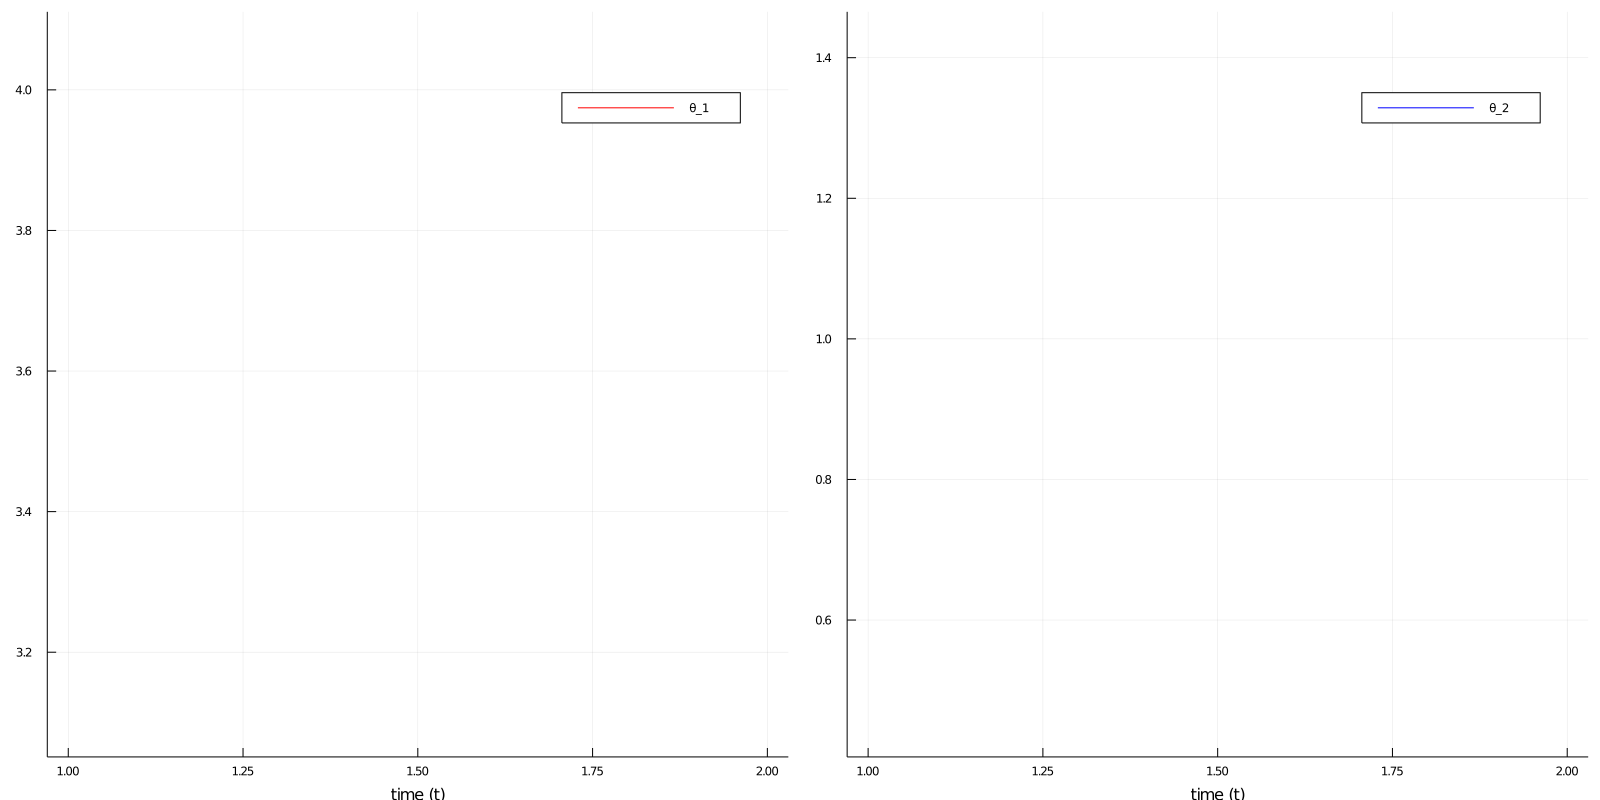

In [24]:
p2a = Plots.plot(1:n:T, estimated_coeffs[1,1:n:T], color="red", label="θ_1", xlabel="time (t)")
p2b = Plots.plot(1:n:T, estimated_coeffs[2,1:n:T], color="blue", label="θ_2", xlabel="time (t)")
plot(p2a, p2b, size=(1600,800))
# Plots.savefig(p1, "viz/estimated_coeffs1.png")